In [6]:
import torch
import numpy as np
from glob import glob
import pickle as pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [119]:
ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    #print(f_in)
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        
    inputs = np.float32(inputs)
    outputs = np.float32(outputs)
    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

In [120]:
inputs.shape, outputs.shape

((43041, 50, 2), (43041, 60, 2))

# Data Normalization and Standardization For Time Series

## Why do we need to normalize time series?
#### 1). Large input values can result in a model that learns large weight values. 
#### 2). Large target values result in large error gradient values causing weight values to change dramatically, making the learning process unstable.

In [121]:
global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
standard_inputs = (inputs - global_mean)/global_std
standard_targets = (outputs - global_mean)/global_std

(array([  6270.,  19766., 346886., 662378., 628304., 465532., 248990.,
        149815.,  51938.,   2581.]),
 array([-2.13738842, -1.67110405, -1.20481967, -0.7385353 , -0.27225093,
         0.19403344,  0.66031781,  1.12660219,  1.59288656,  2.05917093,
         2.5254553 ]),
 <a list of 10 Patch objects>)

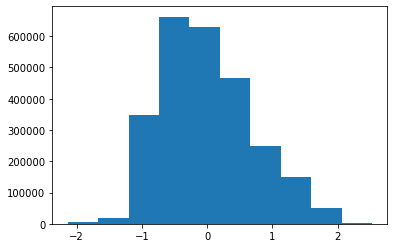

In [122]:
plt.hist(standard_targets[:,:,1].reshape(-1))

In [123]:
# predictions = model(standard_inputs)
# loss_fun(predictions, standard_targets)
# inverse_preds = predictions*global_std + global_mean

In [124]:
global_min = np.min(inputs, axis = (0,1), keepdims = True)
global_max = np.max(inputs, axis = (0,1), keepdims = True)
normal_inputs = (inputs - global_min)/(global_max - global_min)
normal_targets = (outputs - global_min)/(global_max - global_min)

In [125]:
traj_min = np.min(inputs, axis = (1), keepdims = True)
traj_max = np.max(inputs, axis = (1), keepdims = True)
normal_inputs = (inputs - traj_min)/(traj_max - traj_min)
normal_targets = (outputs - traj_min)/(traj_max - traj_min)

# Time Series Forecasting Models

In [126]:
one_batch = torch.from_numpy(standard_inputs[:32]).float()
batch_size = 10  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_size, drop_last = True)

## 4. Seq2Seq with Attention

In [143]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        
        super(Encoder, self).__init__()

        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        
    def forward(self, source):
        
        # hidden = (h, c)
        # h, c: num_layers x bz x  hid_dim
        # outputs: bz x input_length x hid_dim
        outputs, hidden = self.lstm(source)
        
        return outputs, hidden
    
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):

        super(AttnDecoder, self).__init__()

        # Learn the attention scores
        self.attn = nn.Linear(hidden_dim * num_layers+ output_dim, 50)
        
        # Learn the final input to the decoder 
        self.attn_combine = nn.Linear(hidden_dim + output_dim, hidden_dim)
        
        # Decoder LSTM
        self.lstm = nn.LSTM(input_size = hidden_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
      
    def forward(self, x, hidden, encoder_outputs):
        h = hidden[0]
        h = h.transpose(0,1).reshape(h.shape[1], -1)

        # Compute Attention Scores
        energy = self.attn(torch.cat([x, h], 1))
        attn_weights = F.softmax(energy, dim =1)
        
        # Calculate weighted sum of encoder hidden states
        
        attn_applied = torch.einsum("bl,lbh->bh", attn_weights, encoder_outputs)
        x = torch.cat((x, attn_applied), dim = 1)
        x = self.attn_combine(x).unsqueeze(1)
        x = F.relu(x)
        output, decoder_hidden= self.lstm(x, hidden)  
        prediction = self.output_layer(output.float())
        
        return prediction.squeeze(1), decoder_hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, 
                 input_dim = 2, output_dim = 2, hidden_dim = 1024, num_layers = 2, dropout_rate = 0.1):
        
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target_length):

        batch_size = 10
        input_length = 50
        
        encoder_outputs, concat_hidden = self.encoder(source)

        # the last encoder hidden state is used as initial hidden state of the decoder
        decoder_hidden = concat_hidden
        
        # the first input to the decoder is last input position
        decoder_output = source[:,-1]
    
        outputs = torch.zeros(batch_size, 60, 2)
        for t in range(60):    
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden, encoder_outputs)
            outputs[:,t] = decoder_output
        return outputs

In [144]:
def L2_2D(x, y):
    #x1,x2 = zip(*inp)
    #y1,y2 = zip(*out)
    #x1, x2, y1, y2 = torch.tensor(x1), torch.tensor(x2), torch.tensor(y1), torch.tensor(y2)
    #return sum(np.sqrt(np.square(x1-y1) + np.square(x2-y2)))
    return ((x - y) ** 2).sum()
    

def train(encoder, decoder, model, epochs, lr):
        
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lossF = L2_2D
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(X.float(), y)
            loss = lossF(torch.reshape(outputs, [60*batch_size, 2]), torch.reshape(y, [60*batch_size, 2]))
            epoch_loss += loss
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch+1} Loss:{epoch_loss/len(train_loader)}")
        
    return model

n_layers = 1
lr = 50
epochs = 30

input_size = 2
hidden_size = 128
n_layers = 2
dropout_p = 0.1
output_size = 2

encoder_net = Encoder(input_size, hidden_size, n_layers, dropout_p)
decoder_net = AttnDecoder(output_size, hidden_size, n_layers, dropout_p)
lewis = Seq2Seq(encoder_net, decoder_net)

encoder_net.to(device)
decoder_net.to(device)
lewis.to(device)

model = train(encoder_net, decoder_net, lewis, epochs, lr)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2